In [1]:
import argparse
import numpy as np
from matplotlib import pyplot
from matplotlib.pyplot import figure
from scipy.ndimage.filters import gaussian_filter1d
from matplotlib.ticker import MaxNLocator

In [2]:
bd1 = 40
bd2 = 160
latency = 200
oracles = {}

In [3]:
def ipToNode(ip):
    return (int(ip, 16)-int('0b000001', 16))/int('00000100', 16)


# i,j are hex ip, size is in bytes
def oracle(i, j, size):
    data_transmission_delay = 0
    data_propagation_delay = 0
    header_transmission_delay = 0
    header_propagation_delay = 0
    size = int(size)
    oversubscription_ratio = 1
    hdr_size = 64
    mss = 1000
    if ipToNode(i)/16 == ipToNode(j)/16:
        header_transmission_delay = 2.0 * 8.0 * ((hdr_size) / bd1);
        header_propagation_delay = 2.0 * latency;
        data_transmission_delay = ((size / mss) * 8.0 * (mss + hdr_size) / (bd1)) + (8.0 * (mss + hdr_size) / bd1);
        data_propagation_delay = 2.0 * latency;
    else:
        header_transmission_delay = (2.0 * (8.0 * (hdr_size) / bd1)) + (2.0 * 8.0 * ((hdr_size) / (4 * bd1/oversubscription_ratio)))
        header_propagation_delay = 4.0 * latency
        data_transmission_delay = ((size / mss) * 8.0 * (mss + hdr_size) / (bd1)) + (8.0 * (mss + hdr_size) / bd1) + (2.0 * 8.0*(mss + hdr_size) / (4*bd1/oversubscription_ratio))
        data_propagation_delay = 4.0 * latency

    return data_propagation_delay + data_transmission_delay + header_transmission_delay + header_propagation_delay

In [4]:
def slowdown(f,dx):
    slowdowns = []
    with open(f, 'r') as f:
        for line in f.readlines():
            tokens = line.split()
            slowdowns.append(
                int(tokens[6])/oracle(tokens[0], tokens[1], tokens[4]))
    slowdowns = np.array(slowdowns)
    slowdowns.sort()
    s = 0
    i = 0
    dx = 0.001
    X = np.arange(1, 100, dx)
    Y = []
    for s in X:
        while i < len(slowdowns) and slowdowns[i] < s:
            i += 1
        Y.append(i)
    Y = np.array(Y)
    Y = Y/len(slowdowns)
    return slowdowns,Y

In [5]:
ccs = ['hpcc','timely','dcqcn','dctcp']

In [6]:
def cdf(experiment, dx=0.001):
    slowdowns = []
    cdfs = []
    for cc in ccs:
        result = slowdown("../experiments/{0}/{1}/fct.txt".format(experiment,cc), dx)
        slowdowns.append(result[0])
        cdfs.append(result[1])
    for i in range(len(ccs)):
        mean = np.mean(slowdowns[i])
        median = np.median(slowdowns[i])
        nn = slowdowns[i][int(len(slowdowns[i])*.99)]
        print("{0}: mean: {1}, median: {2}, 99%: {3}".format(ccs[i],mean,median,nn))
        X = np.arange(1, 100, dx)
    for cdf in cdfs:
        pyplot.plot(X, cdf)
    pyplot.xscale('log')
    pyplot.legend(ccs, loc='lower right')
    pyplot.xlabel('log slowdown')
    pyplot.ylabel('cdf')
    pyplot.show()

In [7]:
def slowdownBySize(f):
    slowdowns = {}
    with open(f, 'r') as f:
        for line in f.readlines():
            tokens = line.split()
            size = int(tokens[4])
            if size not in slowdowns:
                slowdowns[size] = []
            slowdowns[int(tokens[4])].append(int(tokens[6])/oracle(tokens[0], tokens[1], tokens[4]))
    slowdownsm = {}
    for size in slowdowns:
        slowdownsm[size] = np.mean(slowdowns[size])
    lists = sorted(slowdownsm.items())
    return lists

In [8]:
def sdvssize(experiment,ytick,xtick,sigma):
    slowdowns = []
    for cc in ccs:
        result = slowdownBySize("../experiments/{0}/{1}/fct.txt".format(experiment,cc))
        slowdowns.append(result)
    for slowdown in slowdowns:
        x, y = zip(*slowdown)
        pyplot.plot(x,gaussian_filter1d(y, sigma=sigma))
    pyplot.xscale('log')
    pyplot.yscale('log')
    pyplot.legend(ccs, loc='upper left')
    pyplot.xlabel('flow size')
    pyplot.ylabel('log slowdown')
    pyplot.xticks(xtick[0],xtick[1])
    pyplot.yticks(np.arange(ytick[0],ytick[1]),np.arange(ytick[0],ytick[1]).astype(int))
    pyplot.show()

hpcc: mean: 3.784977299105103, median: 2.9955026938179166, 99%: 16.991028216601226
timely: mean: 2.590669000433752, median: 2.2856360149758013, 99%: 6.848233038078715
dcqcn: mean: 2.5548918110218244, median: 2.2555017806593005, 99%: 6.7376267007579225
dctcp: mean: 2.7983055639895897, median: 2.503310199981737, 99%: 7.032006209478587


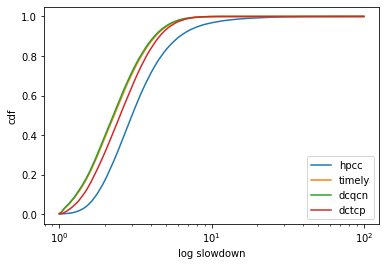

In [9]:
cdf('rpc_32')

hpcc: mean: 2.7118343916080727, median: 2.17114875353849, 99%: 10.435348370011871
timely: mean: 1.9990784710300429, median: 1.667770066660579, 99%: 5.949913249931513
dcqcn: mean: 1.9762945807460508, median: 1.6508766322710255, 99%: 5.855287188384623
dctcp: mean: 2.0335407104374035, median: 1.7166240525979364, 99%: 5.8637339055794


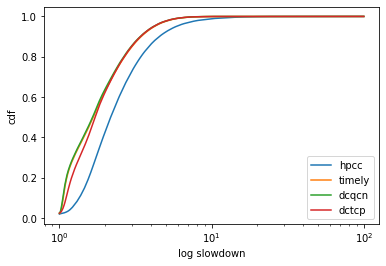

In [9]:
cdf('rpc_32_a1')

hpcc: mean: 17.42876318110218, median: 8.57935348370012, 99%: 112.73080084010594
timely: mean: 5.173524586567437, median: 4.4748196511734095, 99%: 15.130809971692084
dcqcn: mean: 5.037583448657658, median: 4.362672358688705, 99%: 14.7023102912976
dctcp: mean: 5.860024386243266, median: 5.170874805953795, 99%: 16.7292941283901


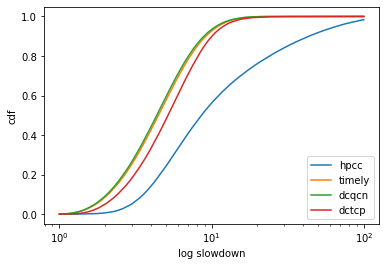

In [9]:
cdf('rpc_32_l7')

hpcc: mean: 16.794023178591, median: 8.26556935439686, 99%: 110.10604054424255
timely: mean: 4.990165835425989, median: 4.297552734910054, 99%: 14.762350470276688
dcqcn: mean: 4.862022390078532, median: 4.1920829148023016, 99%: 14.36250114144827
dctcp: mean: 5.600344779700485, median: 4.919299607341796, 99%: 16.225116427723496


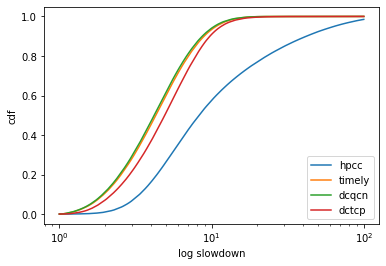

In [25]:
cdf('rpc_32_a1_l7')

hpcc: mean: 5.5895973421363605, median: 3.8663104351847095, 99%: 28.851025021836307
timely: mean: 2.7619778075707746, median: 2.4206186096696296, 99%: 7.509762112726713
dcqcn: mean: 2.7216466947541496, median: 2.3880568257719776, 99%: 7.386643888403638
dctcp: mean: 3.099024635654832, median: 2.7641550634537326, 99%: 7.959589991265478


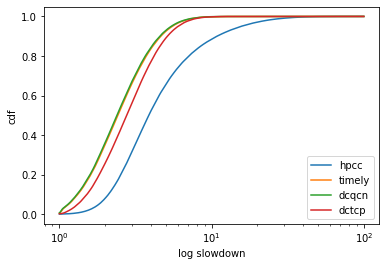

In [14]:
cdf('rpc_64')

hpcc: mean: 4.872159610029286, median: 3.1053473256949085, 99%: 29.00137440271284
timely: mean: 2.0836797713610435, median: 1.7154986384421724, 99%: 6.471766942403535
dcqcn: mean: 2.059259238362533, median: 1.6978369213379232, 99%: 6.370870369418897
dctcp: mean: 2.1455376811771054, median: 1.8012382469300725, 99%: 6.3857704362123


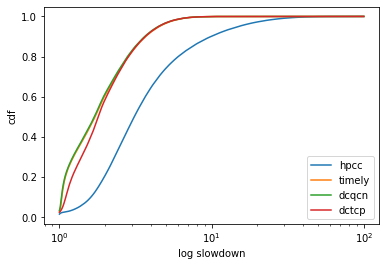

In [10]:
cdf('rpc_64_a1')

hpcc: mean: 85.79951179237528, median: 86.25385346555002, 99%: 203.72925551045574
timely: mean: 5.731698080331912, median: 4.825438010584185, 99%: 17.464676565791503
dcqcn: mean: 5.462344754470021, median: 4.710412063916149, 99%: 16.187188511534707
dctcp: mean: 6.752700780069874, median: 5.996955762215486, 99%: 19.904626727637055


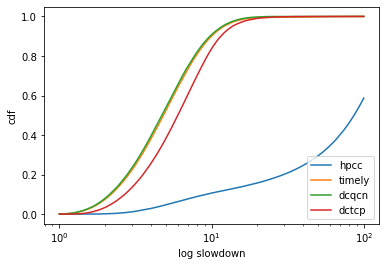

In [19]:
cdf('rpc_64_l7')

hpcc: mean: 86.15348668890972, median: 86.95242254534244, 99%: 203.43857575913273
timely: mean: 5.512391172095771, median: 4.628269023274932, 99%: 16.913309870009762
dcqcn: mean: 5.265043046228742, median: 4.520307763448595, 99%: 15.835495555669732
dctcp: mean: 6.424871862251453, median: 5.673617890356061, 99%: 19.295458048605045


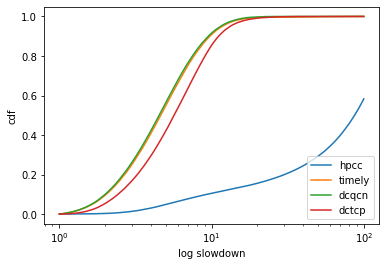

In [23]:
cdf('rpc_64_a1_l7')

hpcc: mean: 7.36463907515005, median: 4.802481020637487, 99%: 35.888124537506506
timely: mean: 2.9560490033779154, median: 2.5084961767204756, 99%: 8.433654452270671
dcqcn: mean: 2.837517992949544, median: 2.474237399621783, 99%: 7.8728382711650715
dctcp: mean: 3.307049646792008, median: 2.9529352920218157, 99%: 8.533895634061446


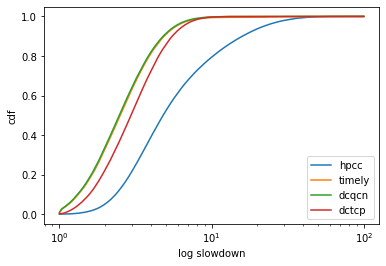

In [53]:
cdf('rpc_128')

hpcc: mean: 8.379016001041464, median: 4.424760873735851, 99%: 48.68394907775372
timely: mean: 2.1463166064283175, median: 1.7512059089538738, 99%: 6.849357305341628
dcqcn: mean: 2.120354414586017, median: 1.7323978403266915, 99%: 6.74342916655247
dctcp: mean: 2.2347264121125336, median: 1.8698269246580972, 99%: 6.761552059637679


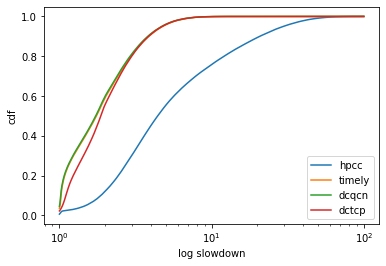

In [14]:
cdf('rpc_128_a1')

hpcc: mean: 215.48372725648855, median: 239.78372434017592, 99%: 325.0501548496725
timely: mean: 7.107526835105654, median: 5.004350864691534, 99%: 57.858038479458436
dcqcn: mean: 5.868892263922766, median: 4.910550332995313, 99%: 22.574170252418668
dctcp: mean: 7.349122379169292, median: 6.607798668018746, 99%: 21.3207101159317


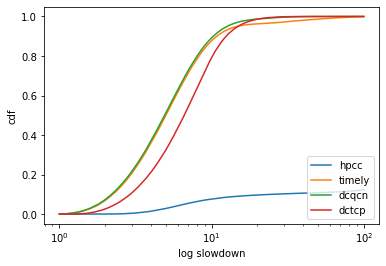

In [10]:
cdf('rpc_128_l7')

hpcc: mean: 205.09290904870227, median: 228.82744196563158, 99%: 301.9419930386165
timely: mean: 6.764994269808422, median: 4.807225861265656, 99%: 55.11832981609888
dcqcn: mean: 5.640379781291965, median: 4.717467865267081, 99%: 21.057534190259542
dctcp: mean: 6.979221378641707, median: 6.241572340833721, 99%: 20.6445788911119


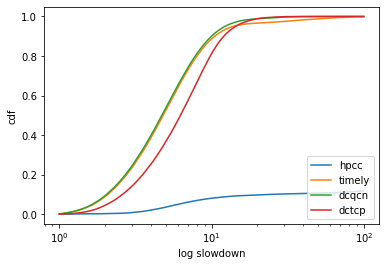

In [27]:
cdf('rpc_128_a1_l7')

hpcc: mean: 2.2971175185130486, median: 1.5252818886539816, 99%: 13.185785939411048
timely: mean: 11.418034360155461, median: 2.907765321233688, 99%: 100.19864341085271
dcqcn: mean: 10.37120308595843, median: 3.0452783650458066, 99%: 73.55576109936575
dctcp: mean: 2.717174428684526, median: 1.9910386839409986, 99%: 9.455162085976038


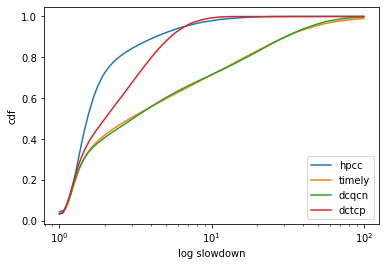

In [10]:
cdf('aditya')

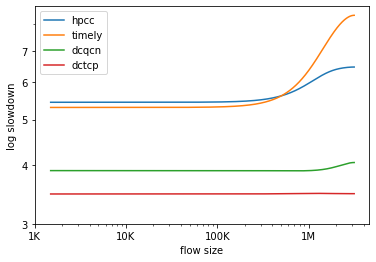

In [13]:
xtick = (np.array([1000,10000,100000,1000000]), ('1K', '10K', '100K', '1M'))
sdvssize('aditya',(3,8),xtick,500)

hpcc: mean: 2.44174594124905, median: 1.371124031007752, 99%: 21.382346035030565
timely: mean: 5.0057903874639464, median: 2.283747119817956, 99%: 28.186206363917208
dcqcn: mean: 4.697046476459809, median: 2.270620945319741, 99%: 24.288231148696266
dctcp: mean: 1.9020492044858586, median: 1.4248590556730092, 99%: 6.346578366445915


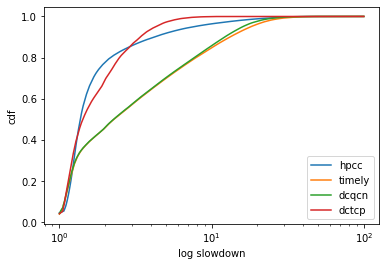

In [15]:
cdf('aditya_a1')

hpcc: mean: 8.446085995064214, median: 1.7190803382663846, 99%: 88.86101695251826
timely: mean: 143.8394648610931, median: 46.66880054851258, 99%: 846.4068005637773
dcqcn: mean: 20.26006083212597, median: 7.040169133192388, 99%: 148.3672480620155
dctcp: mean: 3.9202803375697495, median: 3.0349296216794306, 99%: 12.933657707754094


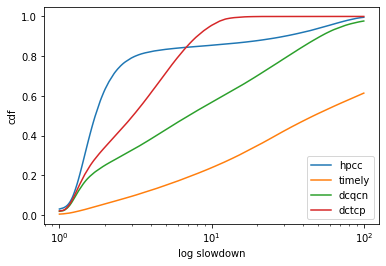

In [9]:
cdf('aditya_l6')

hpcc: mean: 23.379801455415585, median: 1.8880638063806379, 99%: 239.9399913314387
timely: mean: 102.35796123922348, median: 30.191155743481325, 99%: 645.5457188160676
dcqcn: mean: 109.97467047054708, median: 55.12596899224806, 99%: 633.1677237491191
dctcp: mean: 6.107902933196315, median: 5.196881606765327, 99%: 19.059637068357997


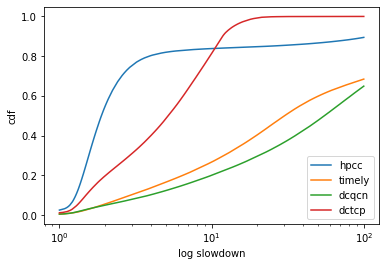

In [12]:
cdf('aditya_l7')

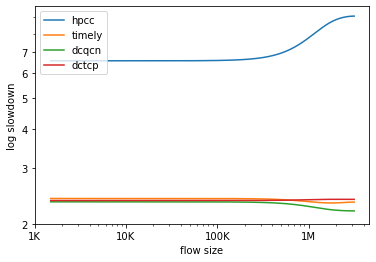

In [18]:
xtick = (np.array([1000,10000,100000,1000000]), ('1K', '10K', '100K', '1M'))
sdvssize('aditya_a1',(2,8),xtick,500)

hpcc: mean: 13.512443611455716, median: 1.4644996476391825, 99%: 177.05106293256776
timely: mean: 7.266706291029433, median: 4.181198182670785, 99%: 34.17723749119098
dcqcn: mean: 7.541927355078356, median: 4.391393648346295, 99%: 35.95533826638478
dctcp: mean: 2.5275687647041027, median: 1.9556025369978858, 99%: 8.895888473537251


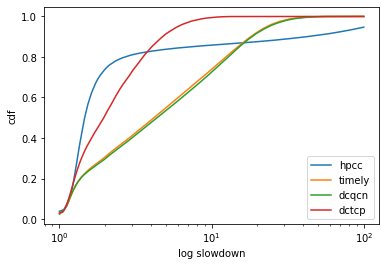

In [10]:
cdf('aditya_a1_l6')

hpcc: mean: 29.95179322289759, median: 1.6137627432808157, 99%: 344.70931414256
timely: mean: 10.03875809317175, median: 7.293503431334454, 99%: 39.58677117711771
dcqcn: mean: 12.802317500045966, median: 8.849101479915433, 99%: 55.229915433403804
dctcp: mean: 3.696708700163399, median: 2.9166666666666665, 99%: 12.574393637345295


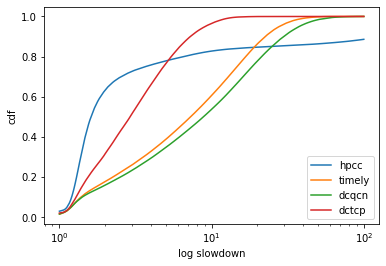

In [14]:
cdf('aditya_a1_l7')

hpcc: mean: 3.948401201639716, median: 2.832632885627226, 99%: 17.915713031336814
timely: mean: 5.666766434814459, median: 3.375722769182685, 99%: 32.04634802400165
dcqcn: mean: 4.45598228707803, median: 3.012907746963775, 99%: 24.716532174632732
dctcp: mean: 3.208958797622562, median: 2.7924774443100118, 99%: 8.941648337430456


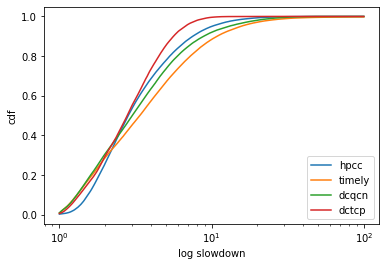

In [10]:
cdf('dctcp')

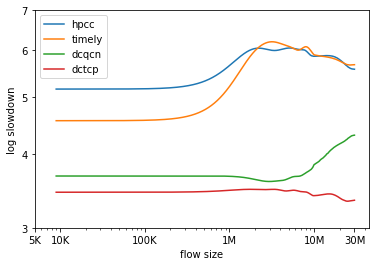

In [49]:
xtick = (np.array([5000,10000,100000,1000000,10000000,30000000]), ('5K', '10K', '100K', '1M','10M','30M'))
sdvssize('dctcp',(3,8),xtick,500)

hpcc: mean: 4.233257651158287, median: 2.5012877940070077, 99%: 25.715845086875568
timely: mean: 3.2729194024243404, median: 2.1257680464940494, 99%: 15.401924270639354
dcqcn: mean: 3.1388863858146006, median: 2.0553396703175197, 99%: 15.248034347196358
dctcp: mean: 2.2896596767053823, median: 1.8880617743705752, 99%: 7.263703260536918


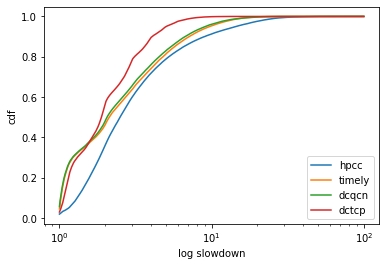

In [46]:
cdf('dctcp_a1')

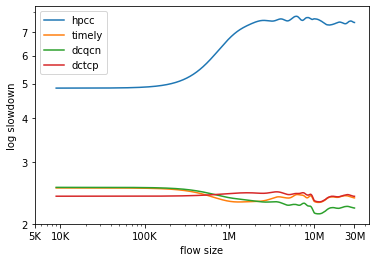

In [56]:
xtick = (np.array([5000,10000,100000,1000000,10000000,30000000]), ('5K', '10K', '100K', '1M','10M','30M'))
sdvssize('dctcp_a1',(2,8),xtick,300)

hpcc: mean: 8.534997669832581, median: 3.8528481556100203, 99%: 42.07308590377522
timely: mean: 6.838354443892911, median: 4.757455050680778, 99%: 34.674374094765156
dcqcn: mean: 6.1735386144017825, median: 4.305578230060167, 99%: 32.00528252611586
dctcp: mean: 4.513731391302562, median: 3.943757321907675, 99%: 12.835234884968743


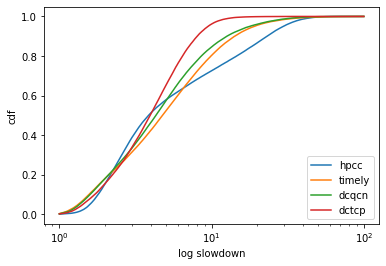

In [13]:
cdf('dctcp_l6')

hpcc: mean: 15.39665943796656, median: 4.474969507812789, 99%: 73.61591752673075
timely: mean: 9.573382795605784, median: 6.82921773337081, 99%: 49.87688571917088
dcqcn: mean: 8.87470264121616, median: 6.439795789751041, 99%: 41.17085661080075
dctcp: mean: 6.819807614011734, median: 6.009989526730587, 99%: 20.707388561566386


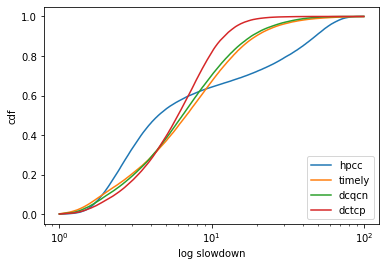

In [11]:
cdf('dctcp_l7')

hpcc: mean: 9.897409605423894, median: 3.305289359808998, 99%: 63.197830312397556
timely: mean: 4.242151818822272, median: 3.05407002238192, 99%: 17.677167390854542
dcqcn: mean: 4.458014974618945, median: 3.0487361253775713, 99%: 21.067918477136352
dctcp: mean: 3.049624814148963, median: 2.534513532430329, 99%: 9.893859335189672


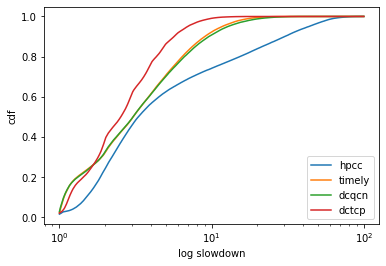

In [14]:
cdf('dctcp_a1_l6')

hpcc: mean: 17.001576511518195, median: 3.9354276992068433, 99%: 97.70931938691079
timely: mean: 5.631775589499383, median: 4.40138441183514, 99%: 20.41531121231837
dcqcn: mean: 6.621813263516196, median: 4.755918816998831, 99%: 28.977290402862028
dctcp: mean: 4.363940865643988, median: 3.6415266435690956, 99%: 14.171465964888489


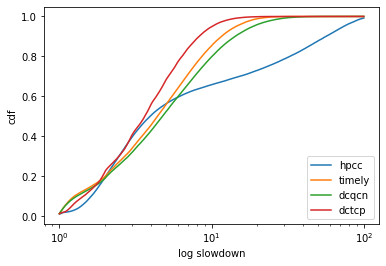

In [22]:
cdf('dctcp_a1_l7')

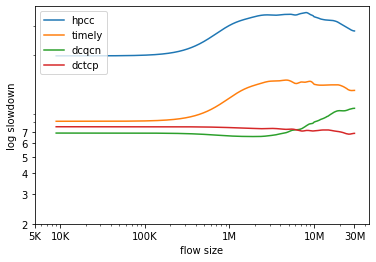

In [12]:
xtick = (np.array([5000,10000,100000,1000000,10000000,30000000]), ('5K', '10K', '100K', '1M','10M','30M'))
sdvssize('dctcp_l7',(2,8),xtick,300)

hpcc: mean: 1.9365520361436468, median: 1.435429880197322, 99%: 8.98060969790405
timely: mean: 5.958872422766189, median: 1.757571987039578, 99%: 35.95900229357798
dcqcn: mean: 5.285327148547467, median: 1.586504580690627, 99%: 34.41155743481325
dctcp: mean: 2.4040936679251854, median: 1.7346308310163732, 99%: 8.534178999295278


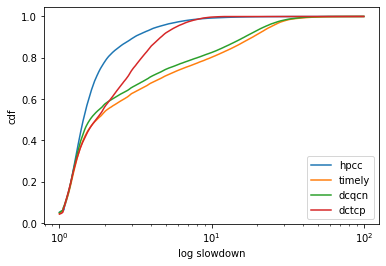

In [20]:
cdf('datamining')

hpcc: mean: 1.7766644845799442, median: 1.3037350246652573, 99%: 9.215062072222178
timely: mean: 7.074830851748141, median: 2.594646933800249, 99%: 29.221115230151376
dcqcn: mean: 5.753176672114479, median: 1.788682417097239, 99%: 30.950493305144466
dctcp: mean: 1.8758529705935527, median: 1.3706835799859056, 99%: 6.3896229739253


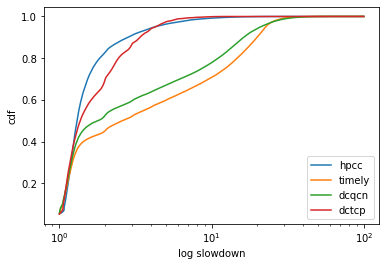

In [21]:
cdf('datamining_a1')

hpcc: mean: 2.193429234974827, median: 1.5019939493949395, 99%: 12.12024067142356
timely: mean: 6.80097563909783, median: 2.310885976598078, 99%: 38.495859760394644
dcqcn: mean: 6.607182327188996, median: 2.061751233262861, 99%: 40.17441860465116
dctcp: mean: 3.0035247200256316, median: 2.219873150105708, 99%: 10.687984496124031


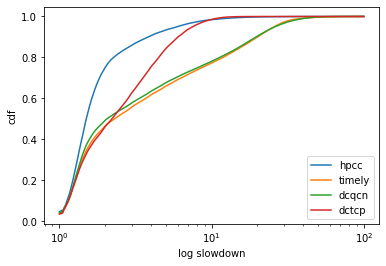

In [12]:
cdf('datamining_l6')

hpcc: mean: 2.427707596930754, median: 1.5481155390793946, 99%: 15.08279676919113
timely: mean: 7.405105674464392, median: 2.9413419091926603, 99%: 39.663054968287526
dcqcn: mean: 8.079036318732232, median: 2.9320753985862353, 99%: 46.155743481324876
dctcp: mean: 3.62848485884503, median: 2.7425315722235486, 99%: 12.566067653276955


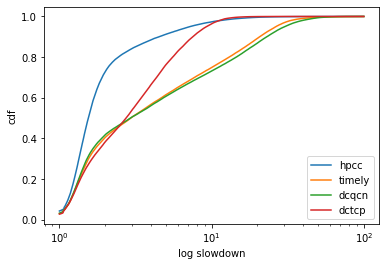

In [13]:
cdf('datamining_l7')

hpcc: mean: 2.0126823557796842, median: 1.342678405931418, 99%: 12.758915653228014
timely: mean: 8.171695062145002, median: 4.326185702232481, 99%: 30.851391825229033
dcqcn: mean: 7.493733294332108, median: 2.999271439417524, 99%: 36.947233967582804
dctcp: mean: 2.2541201783729394, median: 1.687367864693446, 99%: 7.959594472918687


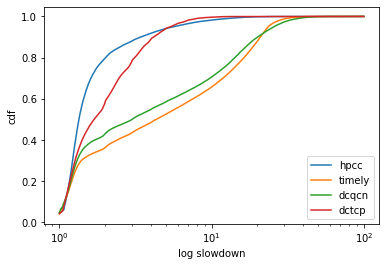

In [15]:
cdf('datamining_a1_l6')

hpcc: mean: 2.2304916029800563, median: 1.3693622269203665, 99%: 15.52369805675094
timely: mean: 9.216226485051676, median: 6.274689749402554, 99%: 32.57575757575758
dcqcn: mean: 9.369884108886632, median: 4.880234704883588, 99%: 42.88413878562577
dctcp: mean: 2.692915432744612, median: 2.049859055673009, 99%: 9.630421313506815


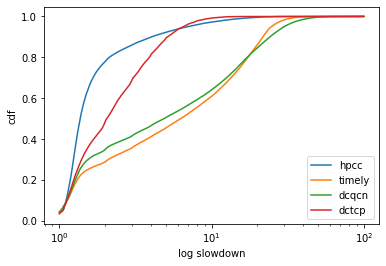

In [15]:
cdf('datamining_a1_l7')

hpcc: mean: 2.3648832335247696, median: 1.3909426987060998, 99%: 15.451522206791385
timely: mean: 9.38586721078516, median: 2.8732514987153865, 99%: 73.14787430683919
dcqcn: mean: 8.74191077276445, median: 2.905013688424374, 99%: 61.53373382624769
dctcp: mean: 2.7771379876482922, median: 2.050369685767098, 99%: 9.8137707948244


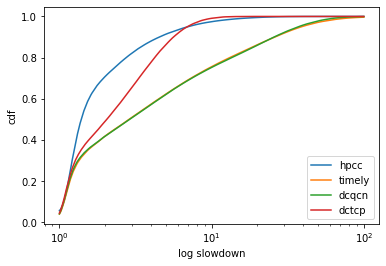

In [11]:
cdf('facebook')

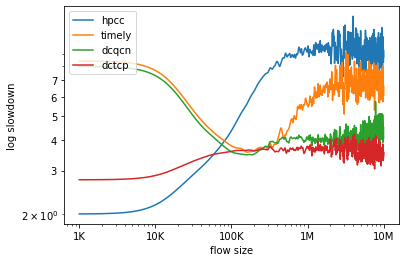

In [34]:
xtick = (np.array([1000,10000,100000,1000000,10000000,]), ('1K', '10K', '100K', '1M','10M',))
sdvssize('facebook',(3,8),xtick,10)